# Data Management Algorithm for Decision Making in Clash Royale
**Analyzing User Behavior in Clash Royale for Strategic Decision Making**

## Project Rationale
This project aims to leverage advanced data management algorithms to analyze user behavior in the popular mobile game Clash Royale.<br>
By utilizing datasets obtained from Kaggle, we will explore how different user behaviors impact game outcomes.<br>
The goal is to apply techniques learned in the course to understand which behaviors lead to winning, prolonged gameplay, and frequent app usage.

we will focuses on handling various steps in the data-driven decision-making process, including data integration, cleaning, and exploration.<br>
In this project we will address common data issues such as missing data, dirty or inconsistent data, and bias, ensuring trustworthy decision-making.

## Data Description
We will use the following datasets:
1. **BattlesStaging_01012021_WL_tagged.csv**: Contains data on games played on January 1, 2021. each row present 1 game between 2 players.
2. **Wincons.csv**: Contains information about impactful cards in the game.

### Columns in BattlesStaging_01012021_WL_tagged.csv
- `Unnamed: 0`: Index
- `battleTime`: The time the battle started
- `arena.id`: The ID of the arena where the battle took place
- `gameMode.id`: The ID of the game mode
- `average.startingTrophies`: The average starting trophies of both players
- `winner.tag`: The tag of the winning player
- `winner.startingTrophies`: The starting trophies of the winning player
- `winner.trophyChange`: The change in trophies for the winning player
- `winner.crowns`: The number of crowns earned by the winning player
- `winner.kingTowerHitPoints`: The hit points of the winning player's king tower
- `winner.princessTowersHitPoints`: The hit points of the winning player's princess towers
- `winner.clan.tag`: The clan tag of the winning player
- `winner.clan.badgeId`: The clan badge ID of the winning player
- `loser.tag`: The tag of the losing player
- `loser.startingTrophies`: The starting trophies of the losing player
- `loser.trophyChange`: The change in trophies for the losing player
- `loser.crowns`: The number of crowns earned by the losing player
- `loser.kingTowerHitPoints`: The hit points of the losing player's king tower
- `loser.clan.tag`: The clan tag of the losing player
- `loser.clan.badgeId`: The clan badge ID of the losing player
- `loser.princessTowersHitPoints`: The hit points of the losing player's princess towers
- `tournamentTag`: The tag of the tournament (if applicable)
- `winner.card1.id` to `winner.card8.id`: The IDs of the winning player's cards
- `winner.card1.level` to `winner.card8.level`: The levels of the winning player's cards
- `winner.cards.list`: The list of cards of the winning player
- `winner.totalcard.level`: The total level of the cards of the winning player
- `winner.troop.count`: The count of troop cards of the winning player
- `winner.structure.count`: The count of structure cards of the winning player
- `winner.spell.count`: The count of spell cards of the winning player
- `winner.common.count`: The count of common cards of the winning player
- `winner.rare.count`: The count of rare cards of the winning player
- `winner.epic.count`: The count of epic cards of the winning player
- `winner.legendary.count`: The count of legendary cards of the winning player
- `winner.elixir.average`: The average elixir cost of the winning player's deck
- `loser.card1.id` to `loser.card8.id`: The IDs of the losing player's cards
- `loser.card1.level` to `loser.card8.level`: The levels of the losing player's cards
- `loser.cards.list`: The list of cards of the losing player
- `loser.totalcard.level`: The total level of the cards of the losing player
- `loser.troop.count`: The count of troop cards of the losing player
- `loser.structure.count`: The count of structure cards of the losing player
- `loser.spell.count`: The count of spell cards of the losing player
- `loser.common.count`: The count of common cards of the losing player
- `loser.rare.count`: The count of rare cards of the losing player
- `loser.epic.count`: The count of epic cards of the losing player
- `loser.legendary.count`: The count of legendary cards of the losing player
- `loser.elixir.average`: The average elixir cost of the losing player's deck

### Columns in Wincons.csv
- `id`: Index
- `card_id`: The ID of the card
- `card_name`: The name of the card

### Columns in CardMasterListSeason18_12082020.csv
- `team.card1.id`: The ID of the card
- `team.card1.name`: The name of the card


In [19]:
%reload_ext autoreload
%autoreload 2
# Import necessary libraries
import projcore as pc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import networkx as nx
from sklearn.manifold import MDS
import math
import os
from scipy.spatial.distance import pdist, squareform

np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", 20) 
pd.set_option("display.max_colwidth", None)  

## Data Integration, Cleaning, and Exploration
We will start by loading the datasets. We will then clean and explore the data to ensure it is ready for analysis.

In [2]:
pc.download_kaggle_datasets()
org_battles_df = pd.read_csv('BattlesStaging_01012021_WL_tagged.csv')
card_list_df = pd.read_csv('CardMasterListSeason18_12082020.csv')
winning_card_list_df = pd.read_csv('Wincons.csv')
battles_df = pc.feature_preprocessing(org_battles_df, winning_card_list_df)
#org_battles_df.head(20).to_csv('org_battles_df.csv', index=False)
#battles_df.head(100).to_csv('battles_df100.csv', index=False)


File BattlesStaging_01012021_WL_tagged/BattlesStaging_01012021_WL_tagged.csv already exists, skipping download
File CardMasterListSeason18_12082020.csv already exists, skipping download
File Wincons.csv already exists, skipping download
clash-royal-data.csv already exists, skipping download


## Feature Engineering
We will create new features to enhance our analysis. This includes calculating the elixir variability, trophy efficiency, and other metrics that can help us understand the factors influencing game outcomes.

In the next section, we create new features to enhance our analysis. These features include:

- `battleTime`: Converted to datetime format for easier time-based analysis.  
- `deck_elixir_variability`: Standard deviation of elixir averages between the winner and loser, indicating how different their decks' elixir costs are.  
- `winner.trophy_eff`: The ratio of the winner's trophy change to their starting trophies, measuring the impact of the match on their ranking.  
- `loser.trophy_eff`: The absolute ratio of the loser's trophy change to their starting trophies, showing how much they lost relative to their ranking.  
- `winner.card_level_std`: Standard deviation of the winner's card levels, indicating how balanced their deck is in terms of card levels.  
- `loser.card_level_std`: Standard deviation of the loser's card levels, reflecting deck balance in terms of card levels.  
- `winner.spell_troop_ratio`: Ratio of the number of spells to troops in the winner's deck, adjusted to avoid division by zero.  
- `loser.spell_troop_ratio`: Ratio of the number of spells to troops in the loser's deck, adjusted to avoid division by zero.  
- `winner_loser.elixir_gap`: Difference between the winner's and loser's average elixir costs, indicating whether the winner had a more expensive or cheaper deck.  
- `winner.rarity_diversity`: Number of different card rarities in the winner's deck, showing how varied their deck composition is.  
- `loser.rarity_diversity`: Number of different card rarities in the loser's deck, reflecting deck variety.  
- `winner.princessTowersHitPoints`: Total hit points of the winner's Princess Towers, calculated from stored list data.  
- `loser.princessTowersHitPoints`: Total hit points of the loser's Princess Towers, computed similarly to the winner.  
- `winner_loser.princess_tower_gap`: Difference in Princess Tower hit points between the winner and loser, showing who had more tower health remaining.  
- `winner.has_legendary`: Binary flag (1 or 0) indicating whether the winner's deck contains at least one legendary card.  
- `loser.has_legendary`: Binary flag (1 or 0) indicating whether the loser's deck contains at least one legendary card.  
- `winner_loser.elixir_advantage`: Binary flag (1 or 0) indicating whether the winner had a higher average elixir cost than the loser.  
- `winner.balanced_deck`: Binary flag indicating whether the winner's deck contains a balanced mix of troops, spells, and structures.  
- `loser.balanced_deck`: Binary flag indicating whether the loser's deck is balanced in terms of troop, spell, and structure counts.  
- `winner.crown_dominance`: Binary flag indicating whether the winner achieved at least two crowns in the match.  
- `winner.count`: Total number of battles in which the winner appeared as a winner.  
- `winner.losing_count`: Total number of battles in which the winner appeared as a loser.  
- `winner.total_games_for`: Total number of battles the winner has participated in, summing both wins and losses.  
- `winner.win_lose_ratio`: Ratio of the winner's total wins to their total games played, defaulting to 1.0 if no losses.  
- `winner.win_lose_ratio_Z_score`: Z-score normalization of the winner's win-lose ratio to standardize across all players.  
- `winner.winning_card_count`: Number of cards in the winner's deck that are classified as "winning cards."  
- `loser.winning_card_count`: Number of cards in the loser's deck that are classified as "winning cards."  
- `winner.card_set`: Ordered tuple of the winner's deck card IDs, facilitating set-based analysis.  
- `loser.card_set`: Ordered tuple of the loser's deck card IDs, enabling comparisons between card sets.  
- `winner.avg_card_level`: Average level of all cards in the winner's deck.  
- `winner.max_card_level`: Maximum card level in the winner's deck.  
- `winner.min_card_level`: Minimum card level in the winner's deck.  
- `winner.level_variance`: Variance of the card levels in the winner's deck, indicating level consistency.  
- `winner.deck_weighted_strength`: Computed deck strength score for the winner, based on weighted win rates of individual cards.  
- `winner.synergy_score`: Normalized synergy score of the winner's deck, reflecting how well the cards complement each other.  
- `winner.deck_weighted_strength (normalized)`: Min-max normalized version of the winner's deck strength score for comparative analysis.  
- `winner.elixir_score`:
- `loser.elixir_score`:
- `deck_final_score`:






These features help us understand the factors influencing game outcomes by providing more detailed metrics on player performance, deck composition, and game dynamics.

# DAG Construction

in order to build our DAG, we will start with A correlation matrix: 

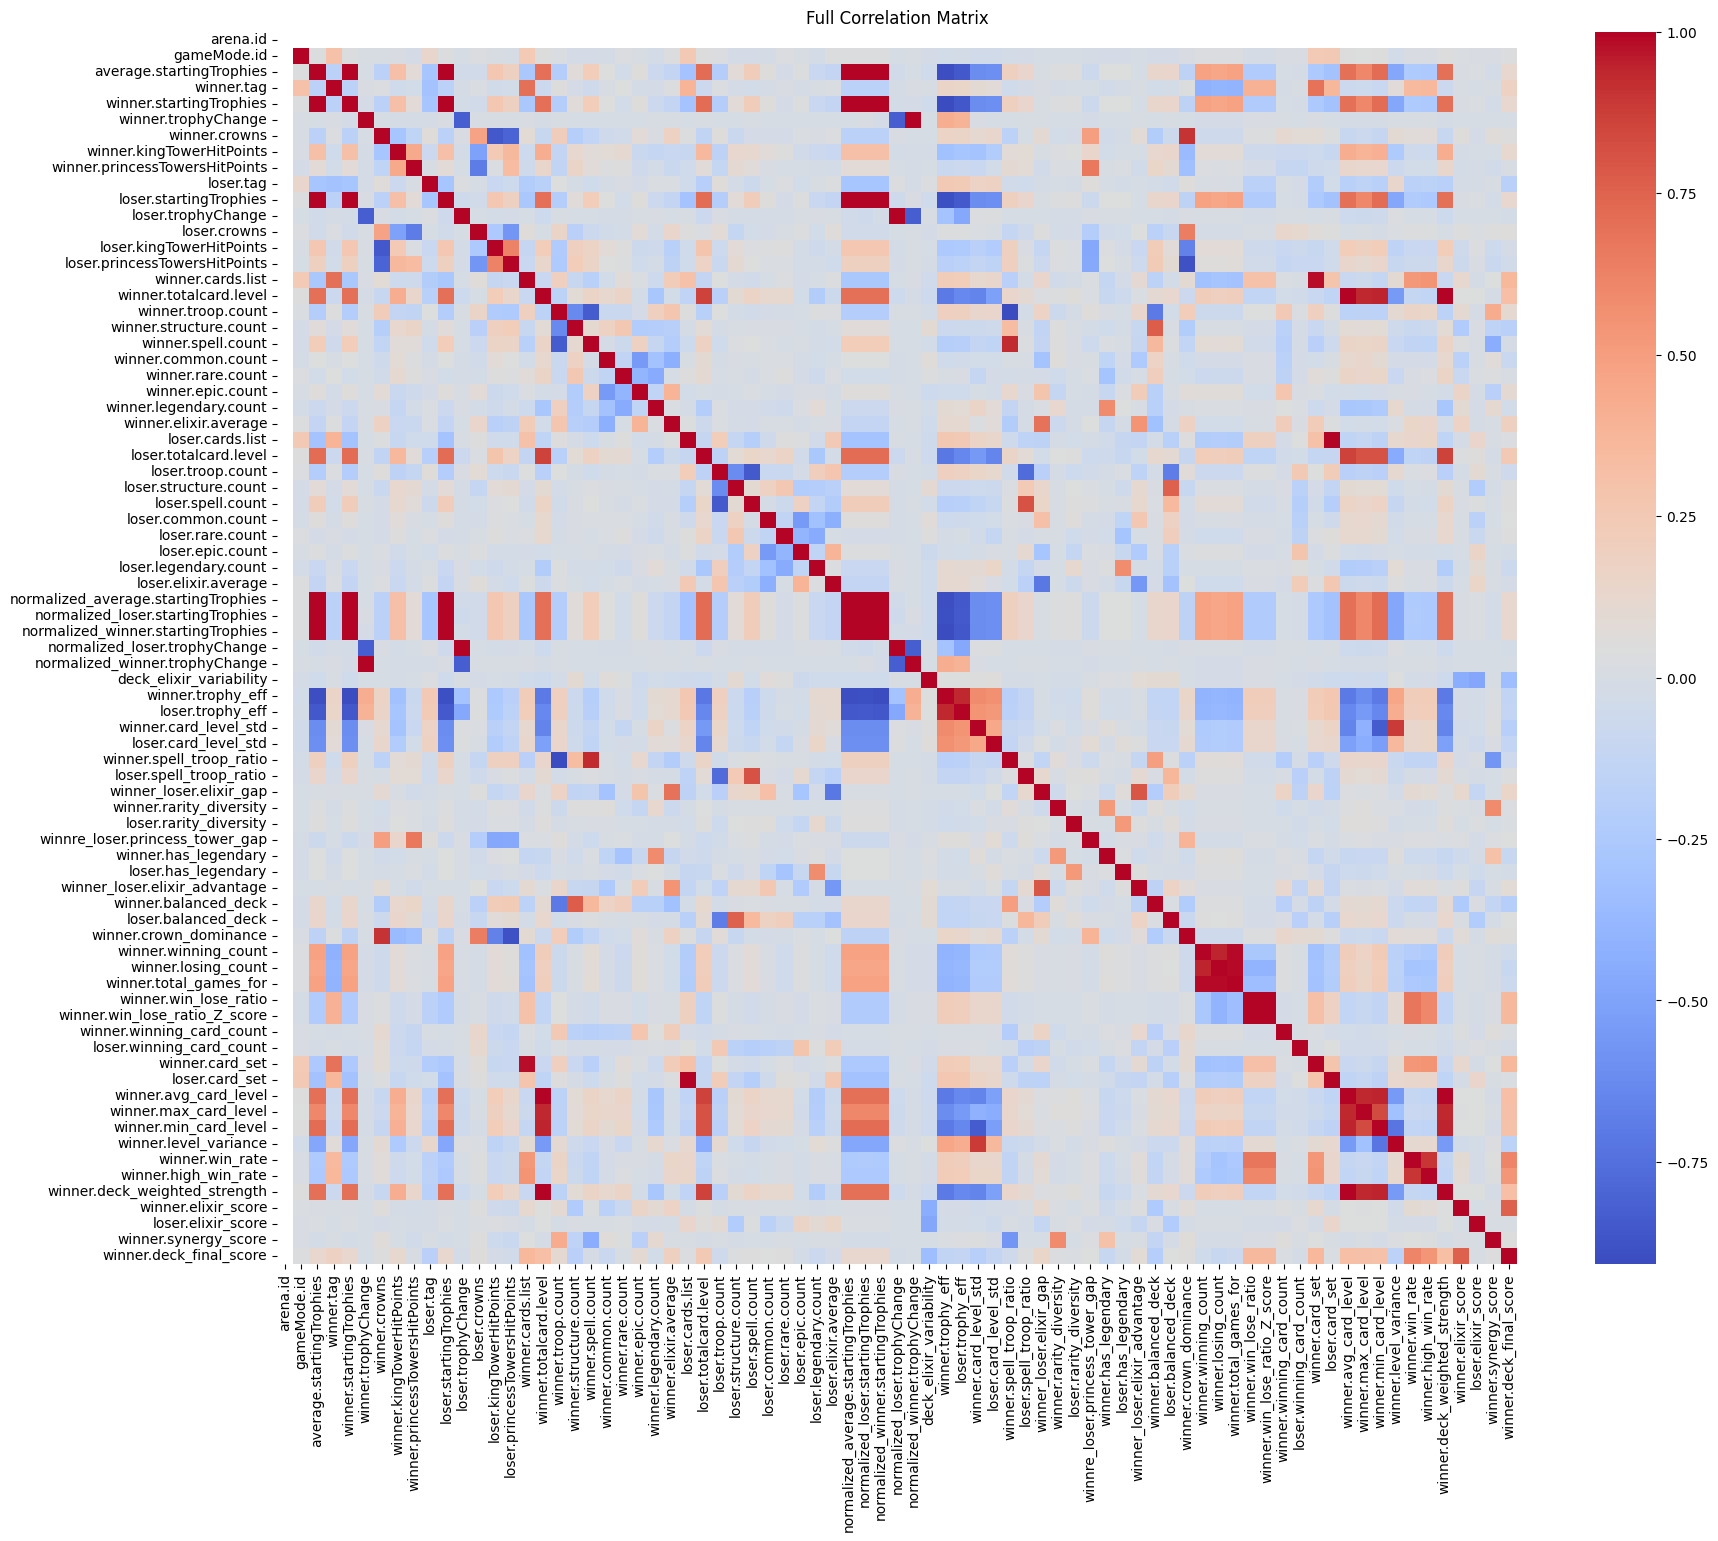

In [3]:
# Calculate the correlation matrix for the specified features
battles_df_for_dag = battles_df.copy()
battles_df_for_dag['loser.card_set'] = pd.factorize(battles_df_for_dag['loser.card_set'])[0]
battles_df_for_dag['winner.card_set'] = pd.factorize(battles_df_for_dag['winner.card_set'])[0]

correlation_matrix = battles_df_for_dag.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Full Correlation Matrix')
plt.show()

now we will look at the feature-pairs that satisfies ${corr(f_1,f_2)>0.55}$

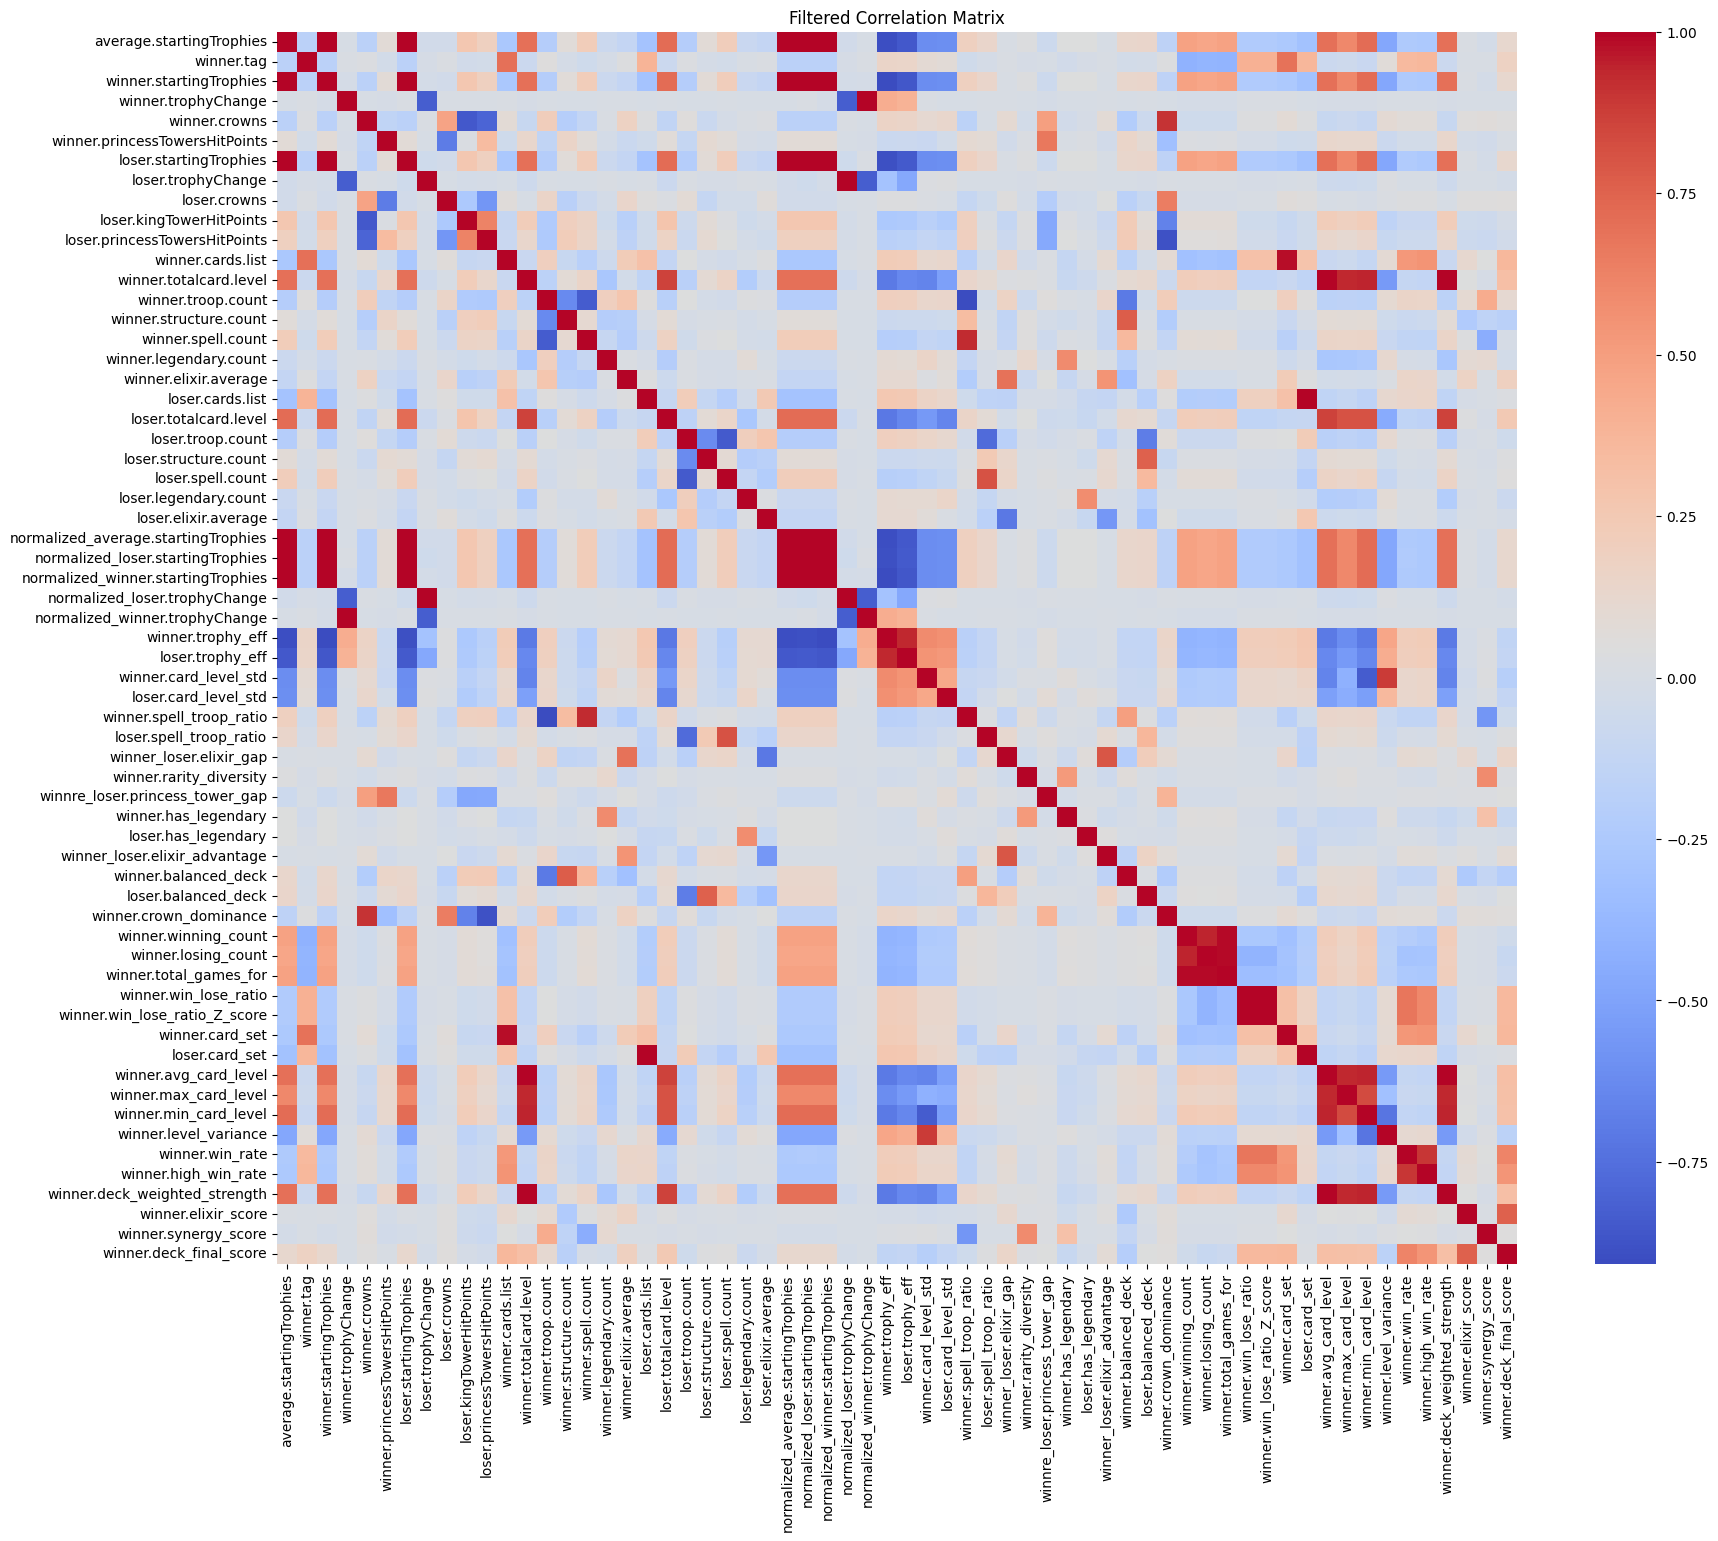

In [4]:
potential_features = set()
# Iterate over the correlation matrix and print tuples with correlation >= 0.55
for i in range(len(correlation_matrix.columns)):
	for j in range(i+1, len(correlation_matrix.columns)):
		if abs(correlation_matrix.iloc[i, j]) > 0.55:
			potential_features.add(correlation_matrix.columns[i])
			potential_features.add(correlation_matrix.columns[j])

for feature in battles_df_for_dag.columns:
	if feature not in potential_features:
		battles_df_for_dag.drop(feature, axis=1, inplace=True)

correlation_matrix = battles_df_for_dag.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Filtered Correlation Matrix')
plt.show()

# ADD explaination about what we're doing

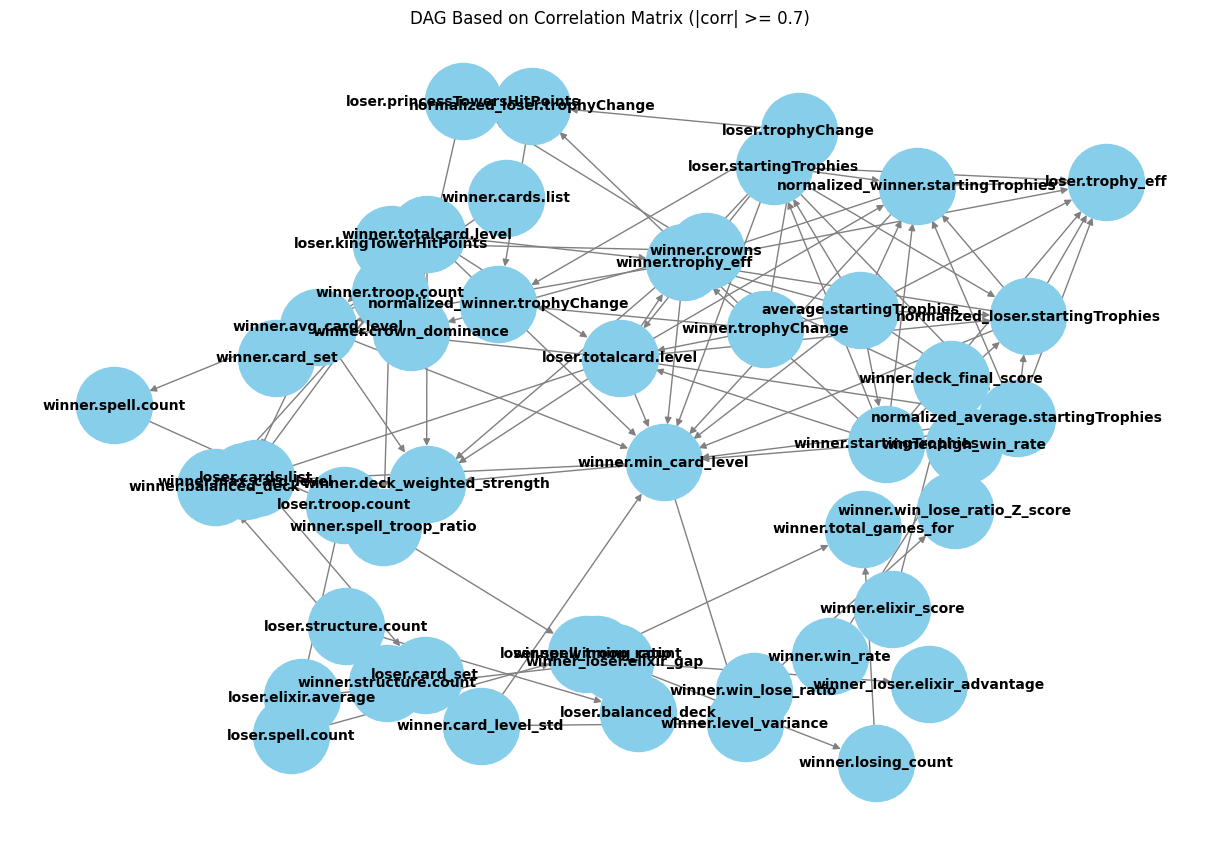

In [5]:
G = nx.DiGraph()
np.fill_diagonal(correlation_matrix.values, 1)  # Self-correlation is 1

# Add edges based on correlation threshold
correlation_threshold = 0.7
for i in range(len(correlation_matrix.columns)):
	for j in range(i+1, len(correlation_matrix.columns)):
		if abs(correlation_matrix.iloc[i, j]) >= correlation_threshold:
			G.add_edge(correlation_matrix.columns[i], correlation_matrix.columns[j])

# Use Kamada-Kawai layout
pos = nx.kamada_kawai_layout(G)

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", 
		font_size=10, font_weight="bold", edge_color="gray")
plt.title("DAG Based on Correlation Matrix (|corr| >= 0.7)")
plt.show()

# ADD explaination about what we're doing

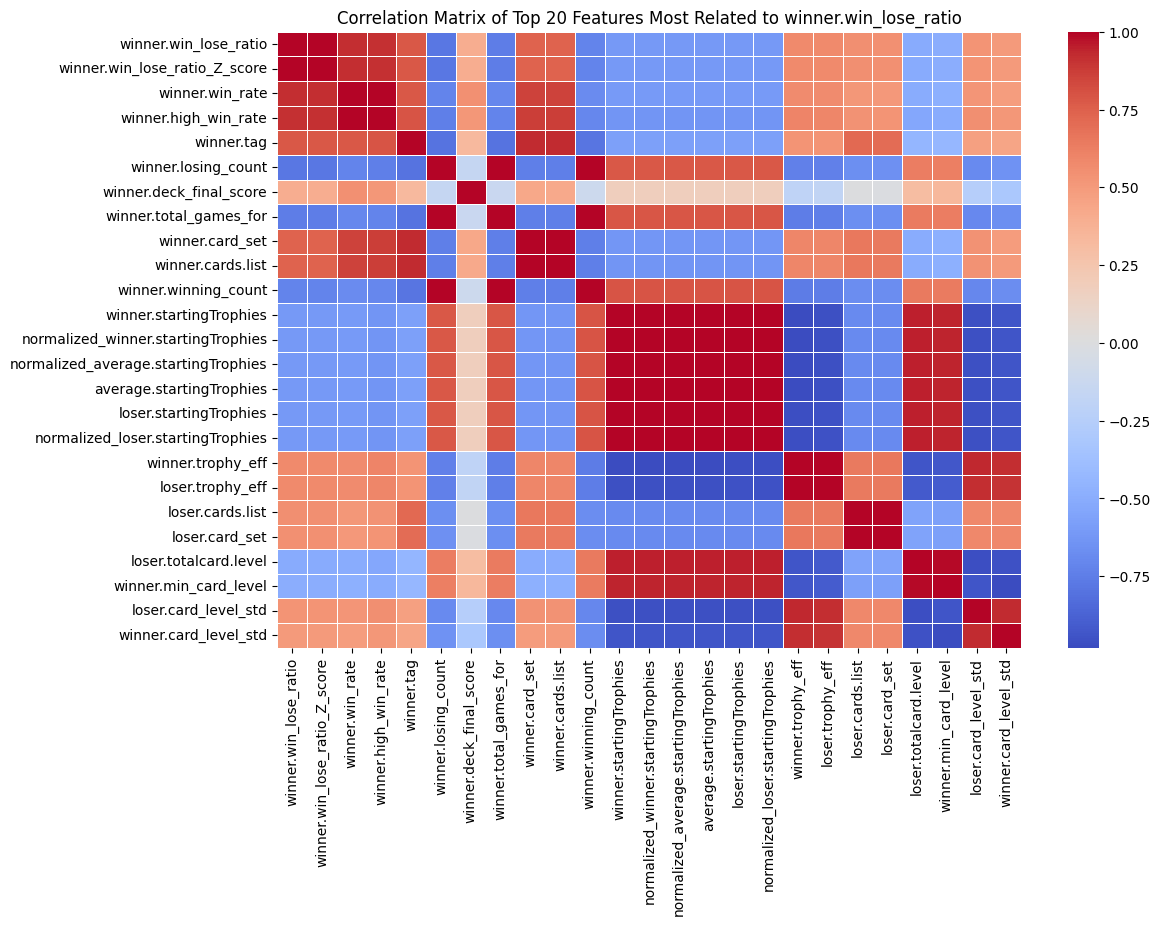

In [6]:
target_col = 'winner.win_lose_ratio'
sorted_corr = correlation_matrix[target_col].abs().sort_values(ascending=False)

plt.figure(figsize=(12, 8)),
sns.heatmap(correlation_matrix[sorted_corr.index[0:25]].corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title(f'Correlation Matrix of Top 20 Features Most Related to {target_col}')
plt.show()

# ADD explaination about what we're doing

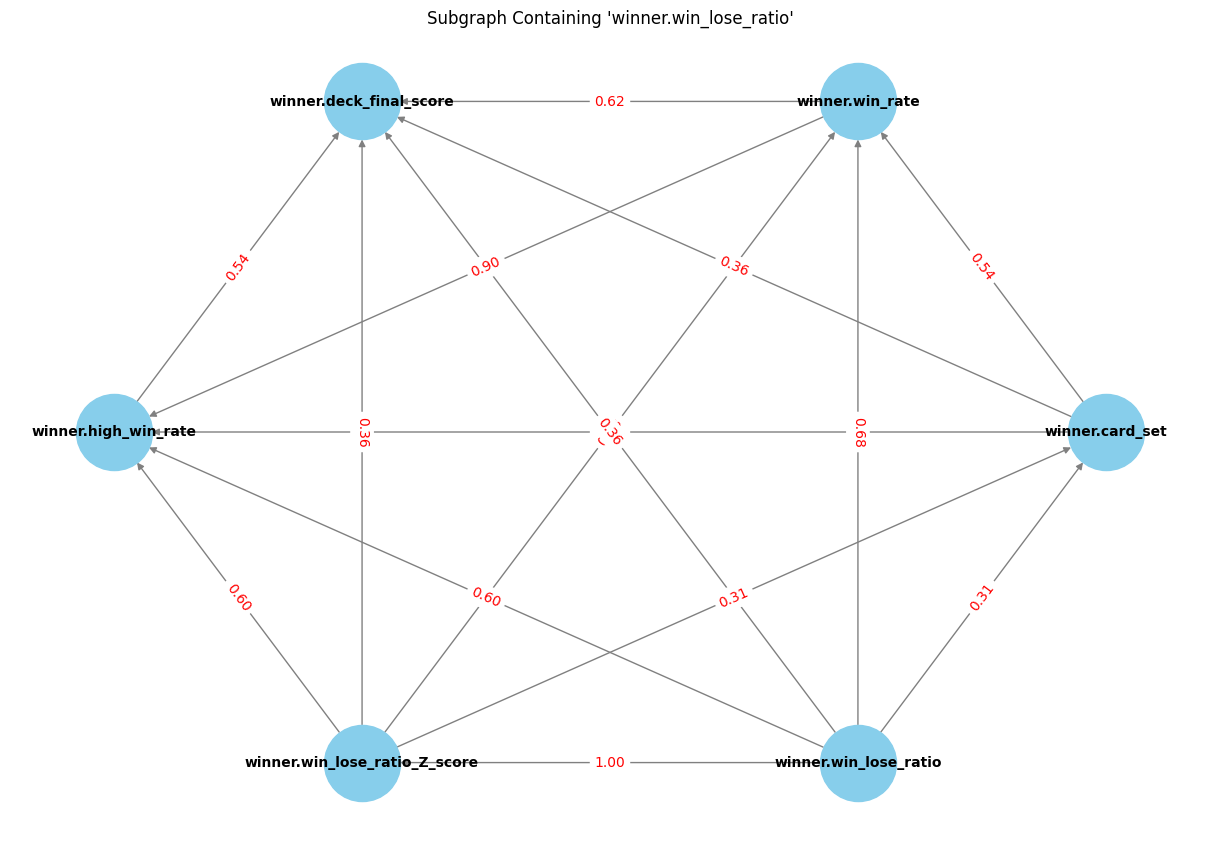

In [7]:
G = nx.DiGraph()
np.fill_diagonal(correlation_matrix.values, 1)  # Self-correlation is 1

# Add edges based on correlation threshold
correlation_threshold = 0.3
for i in range(len(correlation_matrix.columns)):
	for j in range(i+1, len(correlation_matrix.columns)):
		if abs(correlation_matrix.iloc[i, j]) >= correlation_threshold:
			G.add_edge(correlation_matrix.columns[i], correlation_matrix.columns[j])

# Extract the subgraph containing the node 'win_lose_ratio'
target_node = 'winner.win_lose_ratio'
subgraph_nodes = set(nx.single_source_shortest_path_length(G, target_node).keys())
subgraph = G.subgraph(subgraph_nodes)
edge_labels = {(i, j): f'{correlation_matrix.loc[i, j]:.2f}' for i, j in subgraph.edges}
pos = nx.kamada_kawai_layout(subgraph)

# Draw the subgraph with edge labels
plt.figure(figsize=(12, 8))
nx.draw(subgraph, pos, with_labels=True, node_size=3000, node_color="skyblue", 
	font_size=10, font_weight="bold", edge_color="gray")
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color='red')
plt.title("Subgraph Containing 'winner.win_lose_ratio'")
plt.show()

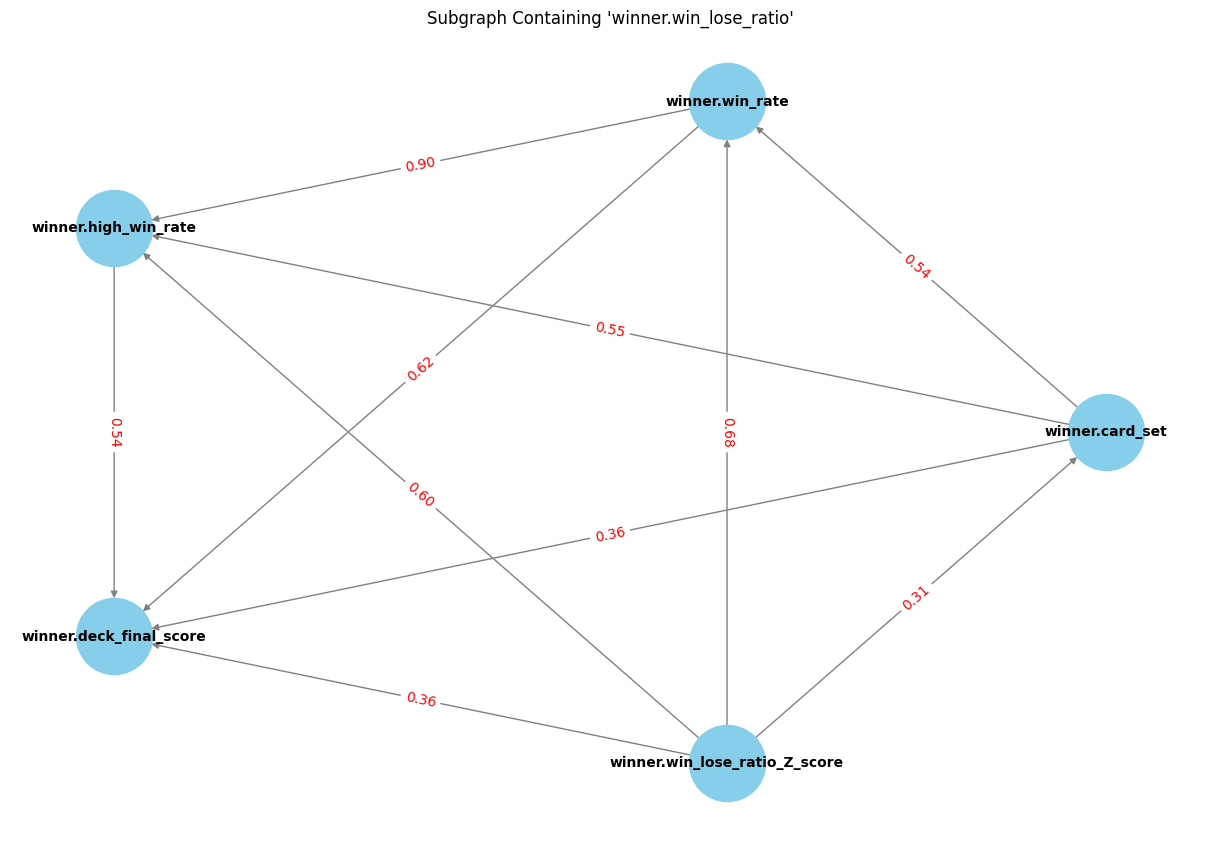

In [8]:
# Extract the subgraph containing the node 'win_lose_ratio'
target_node = 'winner.win_lose_ratio_Z_score'
subgraph_nodes = set(nx.single_source_shortest_path_length(G, target_node).keys())
subgraph = G.subgraph(subgraph_nodes)
edge_labels = {(i, j): f'{correlation_matrix.loc[i, j]:.2f}' for i, j in subgraph.edges}

pos = nx.kamada_kawai_layout(subgraph)

# Draw the subgraph with edge labels
plt.figure(figsize=(12, 8))
nx.draw(subgraph, pos, with_labels=True, node_size=3000, node_color="skyblue", 
	font_size=10, font_weight="bold", edge_color="gray")
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color='red')
plt.title("Subgraph Containing 'winner.win_lose_ratio'")
plt.show()

## PCA and K-Means to find strong connections and special patterns

In this section, we will test our features in the cleaned and prepared dataset.
First, we denote our hureistic as 95% variance (explained in the article).
We run PCA once to find the best n for our problem: 
We want the cumulative variance to be at least 95%, but we want to reduce the dataset from 94 fetures as much as we can.
Then, we run PCA with our optimal value of n

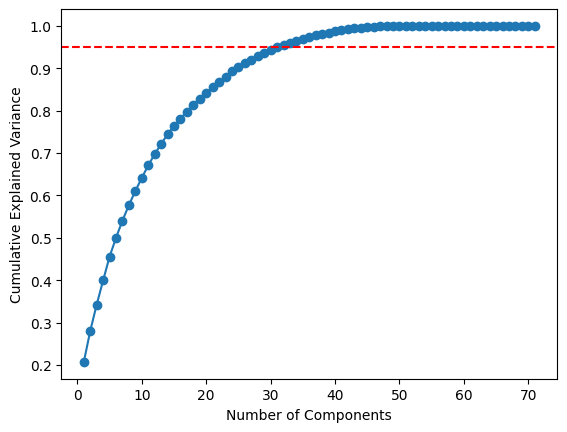

Best component: 32 with a cumulative_variance value of: 0.9552
Explained Variance Ratio: 0.9551684102126166


In [9]:
filtered_df, n = pc.get_pca_optimal_components(battles_df)  
pca_n = PCA(n_components=n)
pca_for_df = pca_n.fit_transform(filtered_df)
df_pca = pd.DataFrame(pca_for_df, columns=[f"PC{i+1}" for i in range(n)])
print("Explained Variance Ratio:", pca_n.explained_variance_ratio_.sum())

We can see that our optimal value is n_components = 33, we will check the properties of the PCA-dataset as follows:
1. Apply K-Means clustering on full PCA-Reduced Data.
2. Check which PC best differentiate clusters.
3. Check which features contribute the most to our chosen PCs.

In [ ]:
# Step 1
pca_loadings = pd.DataFrame(pca_n.components_, columns=filtered_df.columns, index=[f"PC{i+1}" for i in range(n)])
kmeans = KMeans(n_clusters=4, random_state=42)
df_pca["cluster"] = kmeans.fit_predict(df_pca)

# Step 2
cluster_variance = df_pca.groupby("cluster").var().mean()
top_pcs = cluster_variance.sort_values(ascending=False).head(5) # Top 5 PCs that best differentiate clusters

# Step 3
for pcs in top_pcs.index:
    print(f"\nTop Features for {pcs}:")
    print(pca_loadings.loc[pcs].abs().sort_values(ascending=False).head(5))


Top Features for PC5:
winner.trophyChange               0.389523
normalized_winner.trophyChange    0.389523
loser.trophyChange                0.383087
normalized_loser.trophyChange     0.383087
winner.losing_count               0.188384
Name: PC5, dtype: float64

Top Features for PC2:
winner.troop.count               0.282394
winner.crown_dominance           0.281025
winner.balanced_deck             0.273307
winner.crowns                    0.271111
loser.princessTowersHitPoints    0.264857
Name: PC2, dtype: float64

Top Features for PC4:
loser.troop.count          0.301722
loser.balanced_deck        0.290686
loser.elixir.average       0.275996
loser.structure.count      0.249790
winner_loser.elixir_gap    0.249164
Name: PC4, dtype: float64

Top Features for PC3:
winner.losing_count              0.243073
winner.total_games_for           0.236169
winner.winning_count             0.222906
winner.win_lose_ratio            0.215962
winner.win_lose_ratio_Z_score    0.215962
Name: PC3, dtyp

Using the strongest gameplay features and the adrressing the PCs, we can redefine the clusters as follows:

- PC1 (Deck Strength & Player Experience) → “Experienced Strategists”
- - Players with high-level cards, well-optimized decks, and high trophies.
- - Likely long-term players who rely on strong deck composition rather than risky tactics.

- PC3 (Loser’s Deck Balance & Elixir Usage) → “Inefficient Builders”
- - Players who spend too much elixir, leading to inefficient deck play.
- - They try to balance their decks but fail to execute properly, making them vulnerable.

- PC2 (Crowns & Troop Deployment) → “Aggressive Swarmers”
- - Players who deploy many troops, aim for high-crown wins, and overwhelm opponents.
- - They may lack defensive strategy but rely on continuous pressure to win.

- PC5 (Legendary Card Reliance) → “Legendary Reliants”
- - Players who depend heavily on legendary cards, meaning their success might be tied to card rarity rather than skill.
- - Their decks likely lack flexibility but can be powerful if meta-favored.

We'll proceed with checking which cluster is more suitable for each archtype deck

In [11]:
filtered_df['cluster'] = df_pca['cluster']
key_features = [
    "winner.totalcard.level", "winner.deck_weighted_strength", "winner.avg_card_level", 
    "winner.crown_dominance", "winner.troop.count", "winner.crowns", 
    "loser.troop.count", "loser.balanced_deck", "loser.elixir.average",  
    "winner.legendary.count", "winner.has_legendary", 
    "loser.trophyChange", "winner.trophyChange", "deck_elixir_variability" 
]
cluster_means = filtered_df.groupby("cluster")[key_features].mean()
print("Mean Feature Values Per Cluster:\n", cluster_means)

Mean Feature Values Per Cluster:
          winner.totalcard.level  winner.deck_weighted_strength  \
cluster                                                          
0                      0.413886                       0.413886   
1                      0.433606                       0.433606   
2                      0.616000                       0.616000   
3                     -1.626120                      -1.626120   

         winner.avg_card_level  winner.crown_dominance  winner.troop.count  \
cluster                                                                      
0                     0.413886                1.026984            0.213902   
1                     0.433606               -0.944556           -0.274668   
2                     0.616000               -0.218124           -0.304186   
3                    -1.626120                0.147078            0.352055   

         winner.crowns  loser.troop.count  loser.balanced_deck  \
cluster                           

Based on the results (explained on the article), we will set our cluster labels as the following:

/Users/roni/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


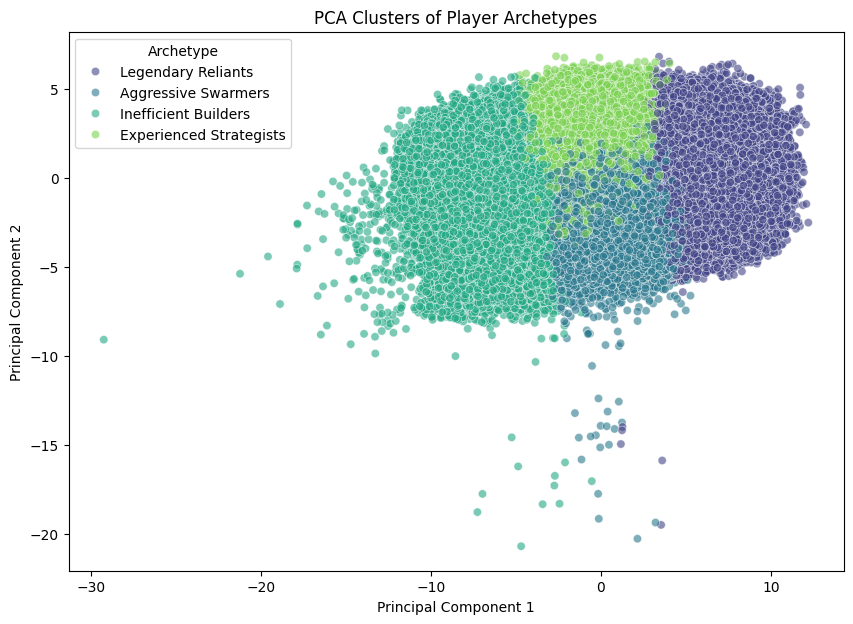

In [12]:
cluster_labels = {
    1: "Aggressive Swarmers",  
    2: "Legendary Reliants",  
    0: "Experienced Strategists", 
    3: "Inefficient Builders"  
}
df_pca['Archetype'] = df_pca['cluster'].map(cluster_labels)
plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_pca["PC1"], y=df_pca["PC2"], hue=df_pca["Archetype"], palette="viridis", alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Clusters of Player Archetypes")
plt.legend(title="Archetype")
plt.show()

The clusters are reasonably well-separated, which means PCA captured meaningful differences. 
We'll visualize key gameplay features to see how different archetypes behave.

/var/folders/x3/fcjjxsd536j13wjtvmqc_hl00000gn/T/ipykernel_59443/952261541.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_pca["Archetype"], y=filtered_df[feature], palette="viridis")
/var/folders/x3/fcjjxsd536j13wjtvmqc_hl00000gn/T/ipykernel_59443/952261541.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_pca["Archetype"], y=filtered_df[feature], palette="viridis")
/var/folders/x3/fcjjxsd536j13wjtvmqc_hl00000gn/T/ipykernel_59443/952261541.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_pca["Archetype"], y=filter

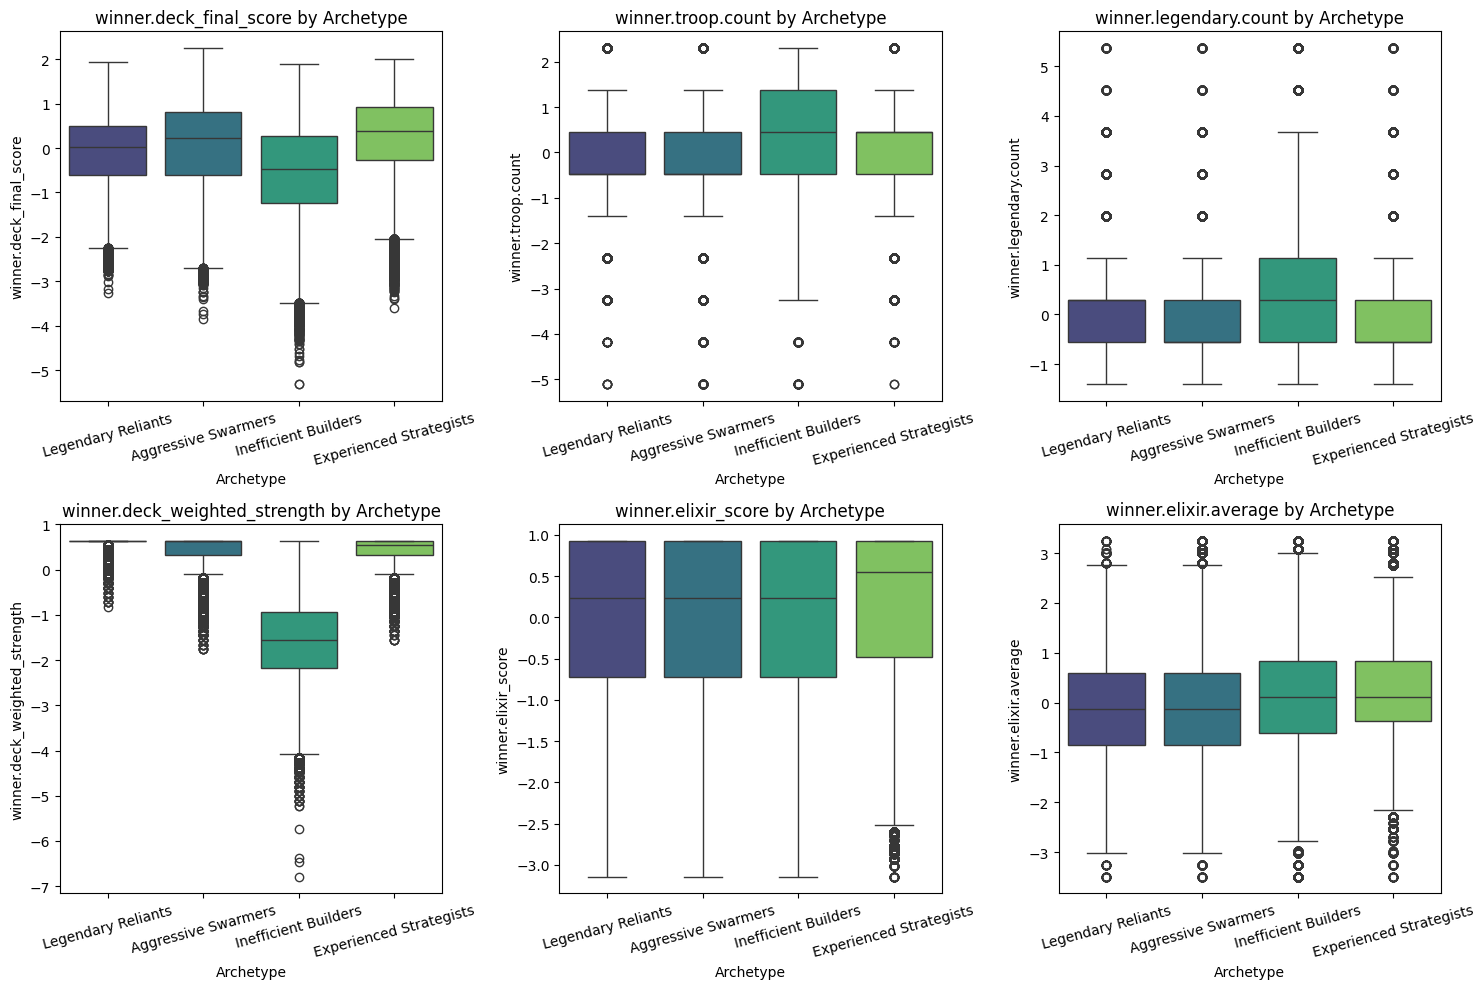

In [13]:
key_features = [
    "winner.deck_final_score", 
    "winner.troop.count", 
    "winner.legendary.count", 
    "winner.deck_weighted_strength",
    "winner.elixir_score",
    "winner.elixir.average"
]
plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df_pca["Archetype"], y=filtered_df[feature], palette="viridis")
    plt.xticks(rotation=15)
    plt.title(f"{feature} by Archetype")
plt.tight_layout()
plt.show()

### Key Observations:

1) **Deck Final Score (Top Left)** <br/>
Experienced Strategists & Inefficient Builders have the highest deck scores.<br/>
Aggressive Swarmers have the weakest decks.<br/>
Legendary Reliants have moderate deck strength.<br/>
Elaboration: Experienced Strategists use optimized decks effectively.<br/>
Inefficient Builders also have strong decks but may not execute them well (Skill issues?).<br/>
Swarmers compensate for weak decks with aggressive tactics.<br/><br/>

2) **Troop Count (Top Center)**<br/>
Aggressive Swarmers have the highest troop count.<br/>
Legendary Reliants also deploy many troops.<br/>
Experienced Strategists & Inefficient Builders use fewer troops.<br/>
Elaboration: Aggressive Swarmers and Legendary Reliants rely on troop-heavy strategies,<br/>
while strategists play with fewer, well-selected troops and balanced decks.<br/><br/>

3) **Legendary Count (Top Right)** <br/>
Legendary Reliants predictably have the most legendary cards.<br/>
Aggressive Swarmers use the fewest legendary cards (due to their high elixir, which is not compitable with the aggressive tactics).<br/>
Strategists and Inefficient Builders have moderate legendary usage.<br/>
Elaboration: Legendary Reliants depend on card rarity while swarmers win without relying on high-rarity cards.<br/><br/>

4) **Deck Weighted Strength (Bottom Left)**<br/>
Experienced Strategists & Inefficient Builders have the highest deck strength.<br/>
Aggressive Swarmers have the weakest deck strength.<br/>
Elaboration: **Strong decks don’t always mean success!**<br/>
Inefficient Builders have powerful decks but lack execution.<br/><br/>

5) **Elixir Score (Bottom Center)**<br/>
Inefficient Builders have high variability in elixir score (some use it well, others don’t).<br/>
Strategists maintain balance.<br/>
Aggressive Swarmers use elixir less efficiently.<br/>
Elaboration: Elixir mismanagement might be the reason why Inefficient Builders struggle.<br/><br/>

6) **Elixir Average (Bottom Right)**<br/>
Inefficient Builders have more variation in elixir use.<br/>
Aggressive Swarmers use elixir more consistently.<br/>
Elixir management is a key weakness for Inefficient Builders.<br/>
Elaboration: Swarmers don’t waste elixir—they cycle troops efficiently.<br/><br/>


Let's understand which decks are most-common in each cluster:

In [14]:
battles_df = battles_df.reset_index(drop=True)
df_pca = df_pca.reset_index(drop=True)
battles_df["Archetype"] = df_pca["Archetype"]
deck_counts = battles_df.groupby(["Archetype", "winner.card_set"]).size().reset_index(name="count")
win_rate_per_deck = battles_df.groupby("winner.card_set")["winner.win_rate"].first().reset_index()
deck_counts = deck_counts.merge(win_rate_per_deck, on="winner.card_set", how="left")

In [ ]:
deck_counts = deck_counts[deck_counts["count"] >= 50]
# Select top 5 decks per archetype
top_decks_per_archetype = (
    deck_counts.sort_values(["Archetype", "winner.win_rate", "count"], ascending=[True, False, False])
    .groupby("Archetype")
    .head(5)
)

top_decks_per_archetype_exploded = top_decks_per_archetype.explode("winner.card_set")
top_decks_per_archetype_exploded["winner.card_set"] = top_decks_per_archetype_exploded["winner.card_set"].astype(int)
top_decks_per_archetype_named = top_decks_per_archetype_exploded.merge(
    card_list_df, left_on="winner.card_set", right_on="team.card1.id", how="left"
)
top_decks_per_archetype_named = top_decks_per_archetype_named.groupby(
    ["Archetype", "count", "winner.win_rate"]
)["team.card1.name"].apply(tuple).reset_index()


 Aggressive Swarmers (Top 5 Decks):
             Archetype  count  winner.win_rate  \
1  Aggressive Swarmers     51         0.603658   
0  Aggressive Swarmers     51         0.596244   
4  Aggressive Swarmers     95         0.594937   
2  Aggressive Swarmers     52         0.593750   
3  Aggressive Swarmers     54         0.592000   

                                                                                           team.card1.name  
1          (Princess, Dark Prince, Ice Spirit, Goblin Gang, Inferno Tower, Rocket, Goblin Barrel, The Log)  
0  (Knight, Skeleton Army, Dart Goblin, Skeleton Barrel, Mother Witch, Bomb Tower, Goblin Barrel, The Log)  
4                   (P.E.K.K.A, Dark Prince, Battle Ram, Electro Wizard, Bandit, Firecracker, Zap, Poison)  
2                        (Knight, Goblins, Hog Rider, Ice Spirit, Executioner, Fireball, The Log, Tornado)  
3                                     (Knight, Archers, Ice Spirit, Bats, Mortar, Arrows, Rocket, The Log)  

 Experi

In [28]:
for archetype in top_decks_per_archetype_named["Archetype"].unique():
    sorted_decks = top_decks_per_archetype_named[
        top_decks_per_archetype_named["Archetype"] == archetype
    ].sort_values("winner.win_rate", ascending=False)
    print(f"\n {archetype} (Top 5 Decks):")
    print(sorted_decks)


 Aggressive Swarmers (Top 5 Decks):
             Archetype  count  winner.win_rate  \
1  Aggressive Swarmers     51         0.603658   
0  Aggressive Swarmers     51         0.596244   
4  Aggressive Swarmers     95         0.594937   
2  Aggressive Swarmers     52         0.593750   
3  Aggressive Swarmers     54         0.592000   

                                                                                           team.card1.name  
1          (Princess, Dark Prince, Ice Spirit, Goblin Gang, Inferno Tower, Rocket, Goblin Barrel, The Log)  
0  (Knight, Skeleton Army, Dart Goblin, Skeleton Barrel, Mother Witch, Bomb Tower, Goblin Barrel, The Log)  
4                   (P.E.K.K.A, Dark Prince, Battle Ram, Electro Wizard, Bandit, Firecracker, Zap, Poison)  
2                        (Knight, Goblins, Hog Rider, Ice Spirit, Executioner, Fireball, The Log, Tornado)  
3                                     (Knight, Archers, Ice Spirit, Bats, Mortar, Arrows, Rocket, The Log)  

 Experi

Following PCA and clustering, deck compositions were analyzed to identify the most frequent decks per archetype. This analysis revealed that Aggressive Swarmers favor fast-cycle, spam-heavy decks (e.g., Hog Rider, Musketeer, Ice Spirit) while Legendary Reliants incorporate high-rarity cards such as Mega Knight and Inferno Dragon. Experienced Strategists often leverage X-Bow and P.E.K.K.A control strategies, while Inefficient Builders display a mix of strong but poorly executed decks, such as Lava Hound and Golem-based decks.

All that left now is to run a deep learning algorithm, such as VAE (autoenconding the decks) or other algorithms to predict the best deck for our desired archetype, or given a deck we may find it's archetype and so we can easiliy address its weakness, making the deck more immune to other decks within the same cluster.

# Deck Similarity

## Sampling
In order to to optimize how much battles to sample, we created a feature called **winner.high_win_rate** which is a boolean feature that shows if the played deck by the winner has a win rate higher than 75%, and we will use it to ensure (as much as possible) that we will have enoguh interest points in our MDS.

In [16]:
high_win_rate_probability = battles_df['winner.high_win_rate'].mean()
print(high_win_rate_probability)

0.24741492819344177


We can see that the ${p(deck\_win\_rate>0.75)~=0.247}$, In other words, ${E[deck\_win\_rate>0.75] = n \times p}$, we'll denote our expectation as k, and assuming we'll be satisfied with k=501, the number of samples will be ${n = \lceil\frac{k}{p}\rceil \approx 2025}$. 

In [17]:
k = 501
sample_size = math.ceil(k / high_win_rate_probability)
battles_df_sampled = battles_df.sample(n=sample_size, random_state=42).copy()

We'll create a **Sparse** matrix repressenting our decks so we'll be able to run MDS on it, using hamming distance.

In [20]:
unique_cards = sorted(set(card for deck in battles_df_sampled["winner.card_set"] for card in deck))
card_to_index = {card: i for i, card in enumerate(unique_cards)}
sparse_deck_matrix = pc.decks_to_sparse_matrix(battles_df_sampled['winner.card_set'], card_to_index, len(unique_cards))

Now, we proceed with creating pair-wised distances matrix using *"hamming"* as our metric, in order to plot a good visualization of our data:

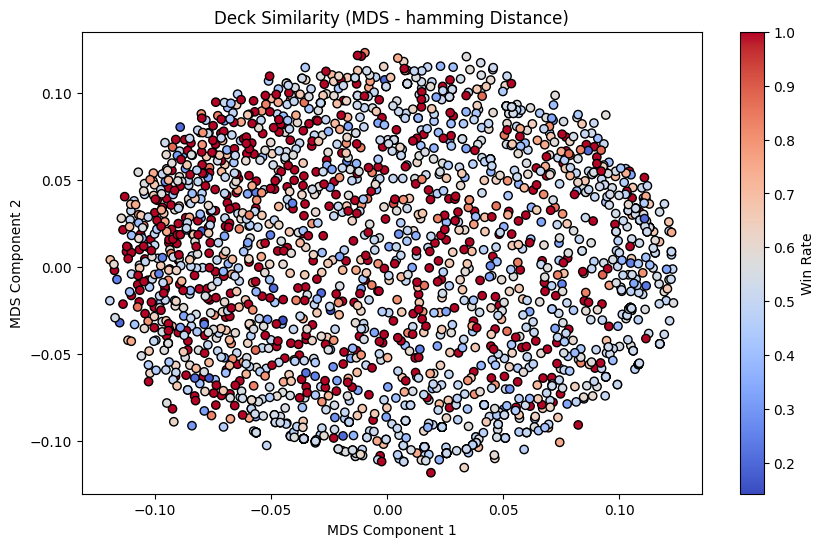

In [21]:
metric = "hamming"
pairwise_dist_matrix = squareform(pdist(sparse_deck_matrix, metric=metric))
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
deck_positions_mds = mds.fit_transform(pairwise_dist_matrix)

plt.figure(figsize=(10, 6))
sc = plt.scatter(deck_positions_mds[:, 0], deck_positions_mds[:, 1], 
                    c=battles_df_sampled["winner.win_rate"], cmap="coolwarm", edgecolors="k")
cbar = plt.colorbar(sc)
cbar.set_label("Win Rate")
plt.xlabel("MDS Component 1")
plt.ylabel("MDS Component 2")
plt.title(f"Deck Similarity (MDS - {metric} Distance)")
plt.savefig(f"images\deck_similarity_mds_{metric}.png", dpi=300)
plt.show()

We can see a dense region of high win-rate decks, which can lead to a strategy hidden within the structural data. We'll begin analysis it by comparing the visualization above to other features which are used for MDS analysis

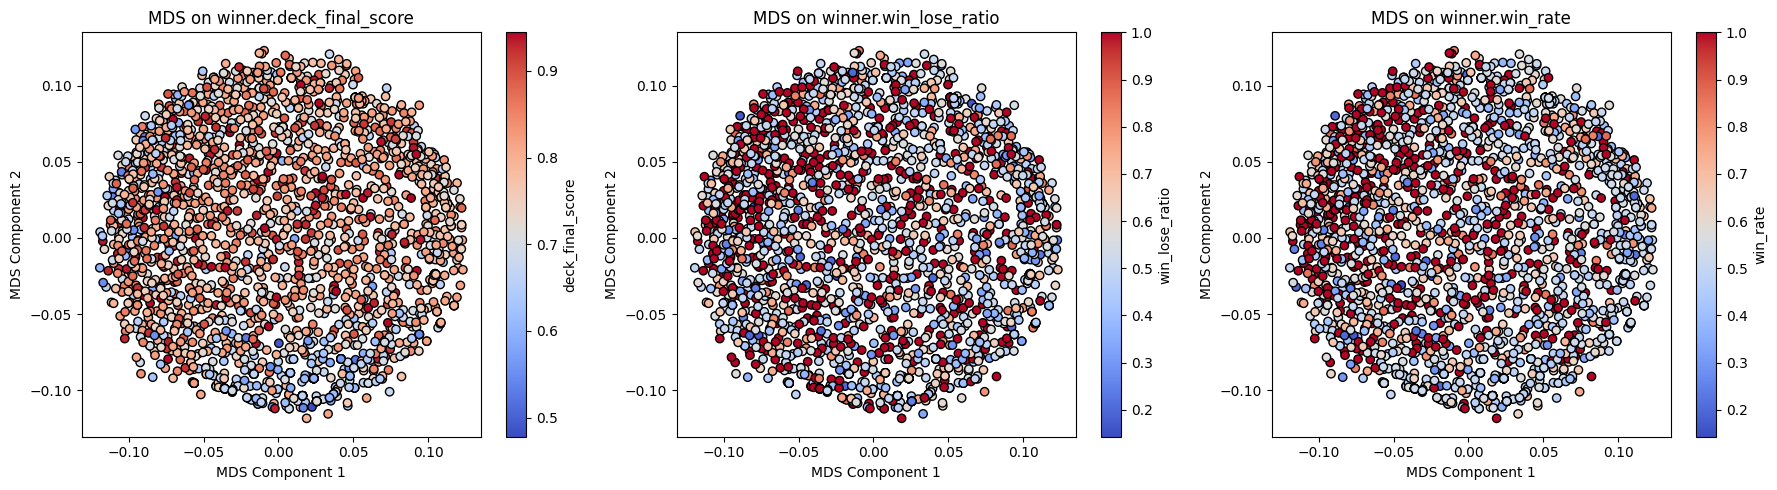

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  
for i, feature in enumerate(["winner.deck_final_score", "winner.win_lose_ratio", "winner.win_rate"]):
    feature_scaled = battles_df_sampled[feature].values.reshape(-1, 1)
    sc = axes[i].scatter(deck_positions_mds[:, 0], deck_positions_mds[:, 1], 
                         c=feature_scaled, cmap="coolwarm", edgecolors="k")
    axes[i].set_xlabel("MDS Component 1")
    axes[i].set_ylabel("MDS Component 2")
    axes[i].set_title(f"MDS on {feature}")
    cbar = fig.colorbar(sc, ax=axes[i])
    cbar.set_label(feature.split(".")[1])
plt.tight_layout()
plt.savefig(f"images/mds_combined_{metric}.png", dpi=300)
plt.show()


# SALEH TASK - ELABORATE ON SUBPLOT